# MNIST Image Reconstruction Using Autoencoder

This project aims to reconstruct images from the MNIST dataset using an autoencoder, which is divided into two main components: an encoder and a decoder. The project leverages the PyTorch library for model building and training, utilizing its DataLoader functionality to handle image batches effectively.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Dataset

Training and testing images are batched into sizes of 32 using the DataLoader, which helps in randomizing the data to prevent the model from memorizing sequences

In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
### DATA LOADER
torch.manual_seed(4)  # for consistent results

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
### for sampling

for i, (x_train, y_train) in enumerate(train_loader):
    break

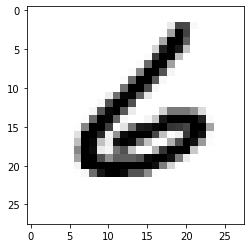

In [5]:
### plot a sample

plt.imshow(x_train[0].reshape((28,28)), cmap="gist_yarg");

Labels:  [    6     7     4     9     6     9     7     4     7     4]


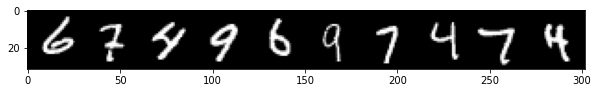

In [6]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

images = x_train
labels = y_train

# Print the first 10 labels
print('Labels: ', labels[:10].numpy())

# Print the first 10 images
im = make_grid(images[:10], nrow=10)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Encoder

The encoder component is designed to compress MNIST images into a lower-dimensional latent space. It accepts input images of size `32x1x28x28` and outputs a compressed representation of size `32x64`.  
It consists of three convolutional layers with 6, 10, and 16 kernels of size `3x3` each, without padding, ensuring that the dimensionality reduction adheres to the formula `n−f+1, n−f+1`. Two pooling layers follow the second and third convolutional layers, utilizing max pooling with a kernel size of `2` and a `stride` of `2` to reduce dimensionality while preserving essential features.  
The final part of the encoder consists of two fully connected layers that further compress the data into a `64-dimensional` array, preparing it for the decoding process.

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 64)

    def forward(self, X):
        X = F.relu(self.conv1(X)) # 1*28*28 --> 6*26*26

        X = F.relu(self.conv2(X)) # 6*26*26 --> 10*24*24
        X = F.max_pool2d(X, kernel_size=2, stride=2) # 10*24*24 --> 10*12*12

        X = F.relu(self.conv3(X)) # 16*12*12 --> 16*10*10
        X = F.max_pool2d(X, kernel_size=2, stride=2) # 16*10*10 --> 16*5*5

        X = X.view(-1, 5*5*16)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))

        return X

### Decoder

The decoder's role is to reconstruct the original image from the compressed data provided by the encoder. It mirrors the encoder's architecture but in reverse, employing ConvTranspose2d layers to upscale the compressed data back to the original image dimensions of `28x28` pixels.  
Initial layers transform the `32x64` compressed data back into a shape suitable for convolutional operations. The subsequent layers use padding and appropriate stride settings in the ConvTranspose2d layers to achieve the desired output dimensions, ensuring detailed reconstruction.  
The final layer uses a sigmoid activation function to scale the output pixel values between `0` and `1`, matching the format of the original MNIST images.

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 120)
        self.fc2 = nn.Linear(120, 5*5*16)
        self.deconv1 = nn.ConvTranspose2d(16, 10, kernel_size=3, stride=1, padding=0, output_padding=0)
        self.deconv2 = nn.ConvTranspose2d(10, 6, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(6, 1, kernel_size=4, stride=2, padding=0, output_padding=0)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))

        X = X.view(-1, 16, 5, 5)

        X = F.relu(self.deconv1(X))  # 16*5*5 --> 10*11*11
        X = F.relu(self.deconv2(X))  # 10*11*11 --> 6*22*22
        X = torch.sigmoid(self.deconv3(X))  # 6*22*22 --> 1*44*44
        return X

#### Samples:

In [9]:
encoder = Encoder()

In [10]:
decoder = Decoder()

In [11]:
enc = encoder(x_train)

In [12]:
enc.shape

torch.Size([32, 64])

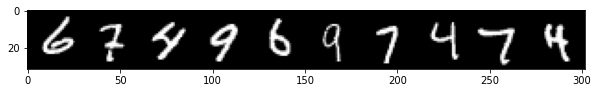

In [13]:
ori_images = x_train
decoded_images = decoder(enc)

ori_im = make_grid(ori_images[:10], nrow=10)
dec_im = make_grid(decoded_images[:10], nrow=10)

plt.figure(figsize=(10,4))
plt.imshow(np.transpose(ori_im.numpy(), (1, 2, 0)));

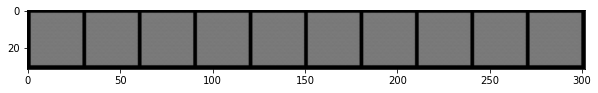

In [14]:
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(dec_im.numpy(), (1, 2, 0)));

####  Optimizer

In [15]:
import torch.optim as optim

#### Training

Before training, the model's performance on a few sample images shows random behavior, indicating the need for training to adapt the weights for accurate reconstruction.  
The model is trained using the Adam optimizer, with Mean Squared Error (MSE) as the loss function, aiming to minimize the difference between the original and reconstructed images.  
After training for 10 epochs, the model significantly reduces the reconstruction error, demonstrating its effectiveness on both training and unseen test data.

In [16]:
encoder = Encoder()
decoder = Decoder()

### loss function
criterion = nn.MSELoss()

### optimizer
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

for epoch in range(10):
    for data in train_loader:
        img, _ = data

        # Forward pass
        features = encoder(img)
        output = decoder(features)

        # Compute loss
        loss = criterion(output, img)

        # Backward pass
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()

        # Update weights
        encoder_optimizer.step()
        decoder_optimizer.step()

    print(f'Epoch {epoch+1}/10, Loss: {loss.item():.4f}')

Epoch 1/10, Loss: 0.0294
Epoch 2/10, Loss: 0.0188
Epoch 3/10, Loss: 0.0158
Epoch 4/10, Loss: 0.0131
Epoch 5/10, Loss: 0.0115
Epoch 6/10, Loss: 0.0107
Epoch 7/10, Loss: 0.0106
Epoch 8/10, Loss: 0.0085
Epoch 9/10, Loss: 0.0076
Epoch 10/10, Loss: 0.0084


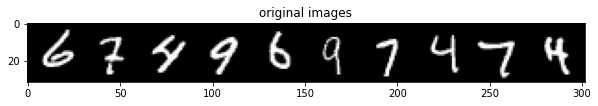

In [17]:
ori_images = x_train
decoded_images = decoder(encoder(x_train))

ori_im = make_grid(ori_images[:10], nrow=10)
dec_im = make_grid(decoded_images[:10], nrow=10)

plt.figure(figsize=(10,4))
plt.title('original images')
plt.imshow(np.transpose(ori_im.numpy(), (1, 2, 0)));

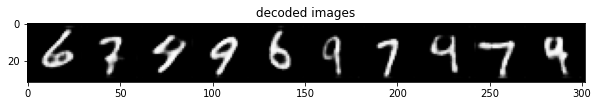

In [18]:
plt.figure(figsize=(10,4))
plt.title('decoded images')
plt.imshow(np.transpose(dec_im.numpy(), (1, 2, 0)));

In [19]:
for i, (x_test, y_test) in enumerate(train_loader):
    break

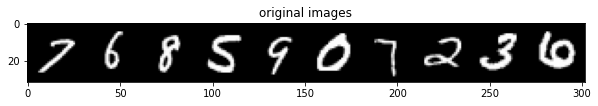

In [20]:
ori_images = x_test
decoded_images = decoder(encoder(x_test))

ori_im = make_grid(ori_images[:10], nrow=10)
dec_im = make_grid(decoded_images[:10], nrow=10)

plt.figure(figsize=(10,4))
plt.title('original images')
plt.imshow(np.transpose(ori_im.numpy(), (1, 2, 0)));

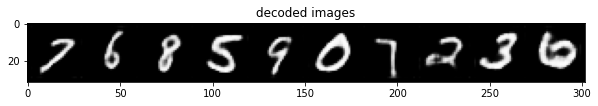

In [21]:
plt.figure(figsize=(10,4))
plt.title('decoded images')
plt.imshow(np.transpose(dec_im.numpy(), (1, 2, 0)));

Post-training evaluations show that the autoencoder can accurately reconstruct MNIST images, proving the model's ability to generalize well from the training to the testing dataset.  
The project highlights the effectiveness of autoencoders in image compression and reconstruction tasks, providing insights into the potential applications in more complex image processing tasks.